# Convolutional neural networks 101

Convolution neural networks are one of the most successful types of neural networks for image recognition and an integral part of reigniting the interest in neural networks. They are able to extract structural relations in the data, such as spatial in images or temporal in time series.

In this lab, we will experiment with inserting 2D-convolution layers in the fully connected neural networks introduced previously. We will also try to visualize the learned convolution filters and try to understand what kind of features they learn to recognize.

If you have not watched Jason Yosinski's [video on visualizing convolutional networks](https://www.youtube.com/watch?v=AgkfIQ4IGaM), you definitely should do so now. If you are unfamiliar with the convolution operation, [Vincent Dumoulin](https://github.com/vdumoulin/conv_arithmetic) has a nice visualization of different convolution variants. For a more in-depth tutorial, please see also [cs231n.github.io/convolutional-networks](http://cs231n.github.io/convolutional-networks).

## Reminder: what are convolutional networks?

Standard ConvNets are, in many respects, very similar to the dense feedforward networks we saw previously:
 * The network is still organized into layers.
 * Each layer is parameterized by weights and biases.
 * Each layer has an element-wise non-linear transformation (activation function).
 * There are no cycles in the connections (more on this in later labs).

*So what is the difference?*
The networks we saw previously are called *dense* because each unit receives input from all the units in the previous layer. This is not the case for ConvNets. In ConvNets each unit is only connected to a small subset of the input units. This is called the *receptive field* of the unit.

#### Example
The input (green matrix) is a tensor of size `1x5x5`, i.e., it has one "channel" (like a grayscale image), and the feature map has size `5x5`. Let us define a `1x3x3` kernel (yellow submatrix). The kernel weights are indicated in red at the bottom right of each element. The computation can be thought of as an elementwise multiplication followed by a sum. Here we use a *stride* of 1, as shown in this animation:

<img src="https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/4_Convolutional/images/convolutions.gif" style="width: 400px;"/>

(GIF courtesy of [Stanford](http://deeplearning.stanford.edu/wiki/index.php/Feature_extraction_using_convolution))

After having convolved the image, we perform an elementwise non-linear transformation on the *convolved features*.
In this example, the input is a 2D *feature map* with depth 1.


# Assignment 1

### Assignment 1.1: Manual calculations

Perform the following computation, and write the result below.

![](https://raw.githubusercontent.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/master/4_Convolutional/images/conv_exe.png)

1. Manually convolve the input, and compute the convolved features. No padding and stride of 1.
 * **Answer:**
2. Perform `2x2` max pooling on the convolved features. Stride of 2.
 * **Answer:**

### Assignment 1.2: Output dimensionality

Given the following 3D tensor input `(channel, height, width)`, a given amount (`channels_out`) of filters `(channels_in, filter_height, filter_width)`, stride `(height, width)` and padding `(height, width)`, calculate the output dimensionality if it is valid.

1. input tensor with dimensionality (1, 28, 28) and 16 filters of size (1, 5, 5) with stride (1, 1) and padding (0, 0)
 * **Answer:** 
2. input tensor with dimensionality (2, 32, 32) and 24 filters of size (2, 3, 3) with stride (1, 1) and padding (0, 0)
 * **Answer:** 
3. input tensor with dimensionality (10, 32, 32) and 3 filters of size (10, 2, 2) with stride (2, 2) and padding (0, 0)
 * **Answer:** 
4. input tensor with dimensionality (11, 8, 16) and 7 filters of size (11, 3, 3) with stride (2, 2) and padding (1, 1)
 * **Answer:** 
5. input tensor with dimensionality (128, 256, 256) and 112 filters of size (128, 3, 3) with stride (1, 1) and padding (1, 1)
 * **Answer:** 
 

# Load packages

In [1]:
"Load packages"
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # sns is for making pretty plots
import torch # PyTorch main library used for building neural networks
from torch import nn # nn contains modules and loss functions
import torch.nn.functional as F # F contains functions that don't have any parameters
import torch.optim as optim # optim contains optimization algorithms

from sklearn.metrics import accuracy_score # for calculating accuracy
from torch.utils.data import TensorDataset, DataLoader # for creating datasets and data loaders
from torchvision.utils import make_grid # for making grids of images

sns.set_style("whitegrid") # set the seaborn style for plots

# Load MNIST data

The code below downloads and loads the same MNIST dataset as before.
Note however that the data has a different shape this time: `(num_samples, num_channels, height, width)`.

In [ ]:
"Load MNIST dataset and create subsets"
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# Load the MNIST dataset
train_dataset_full = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

# Create subsets: 50,000 for training, 10,000 for validation from the original training set
train_dataset = Subset(train_dataset_full, range(50000))
validation_dataset = Subset(train_dataset_full, range(50000, 60000))

# Get the number of classes
num_classes = train_dataset.dataset.targets.unique().size(0)

# Extract a batch from each dataset and print its shape
# batch size means how many samples we process before updating the model
#Batch size: number of samples processed in one forward+backward pass
# Model update: happens once per batch (i.e., every 64 samples here)
x_train, targets_train = next(iter(DataLoader(train_dataset, batch_size=64)))
x_valid, targets_valid = next(iter(DataLoader(validation_dataset, batch_size=64)))
x_test, targets_test = next(iter(DataLoader(test_dataset, batch_size=64)))

print("Information on dataset")
print("Shape of x_train:", x_train.shape)# should be (64, 1, 28, 28), where 64 is batch size, 1 is number of channels, 28x28 is image size ( height x width)
print("Shape of targets_train:", targets_train.shape) # should be (64) where 64 is batch size
print("Shape of x_valid:", x_valid.shape) # should be (64, 1, 28, 28) 
print("Shape of targets_valid:", targets_valid.shape) # should be (64)
print("Shape of x_test:", x_test.shape) # should be (64, 1, 28, 28)
print("Shape of targets_test:", targets_test.shape) # should be (64)
print("Number of classes:", num_classes) # should be 10 classes for MNIST

Information on dataset
Shape of x_train: torch.Size([64, 1, 28, 28])
Shape of targets_train: torch.Size([64])
Shape of x_valid: torch.Size([64, 1, 28, 28])
Shape of targets_valid: torch.Size([64])
Shape of x_test: torch.Size([64, 1, 28, 28])
Shape of targets_test: torch.Size([64])
Number of classes: 10


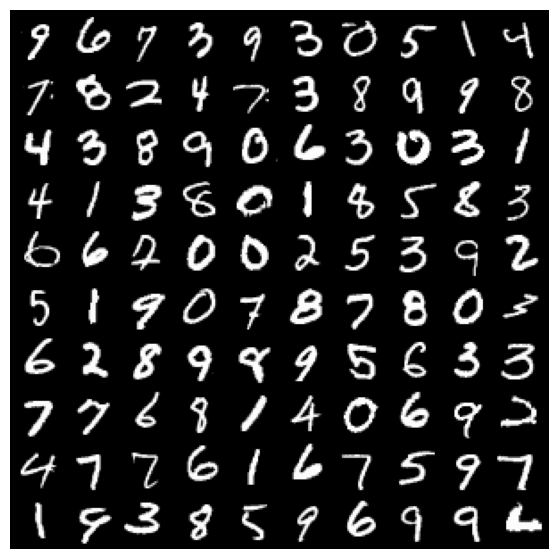

In [3]:
" Extract the 100 images from the training set"
images, labels = next(iter(DataLoader(train_dataset, batch_size=100, shuffle=True)))

# Plot a few MNIST examples
plt.figure(figsize=(7, 7))
# imshow is used to display images
# make_grid creates a grid of images, where nrow specifies how many images per row that is 10 here
# permute(1, 2, 0) changes the dimensions from (C, H, W) to (H, W, C)
plt.imshow(make_grid(images, nrow=10).permute(1, 2, 0))# her we have 10 images per row, total images is 100
plt.axis('off') # turn off axis
plt.show()

# Define a simple feed forward neural network

In [4]:
"Define a simple fully connected neural network model ffnn"
# Get input dimensions for building the model
channels, height, width = x_train.shape[1:]
# n_features is the total number of input features
# channels = 1, height = 28, width = 28 => for MNIST 1*28*28=784
n_features = channels * height * width 

# Define a class to print the size of a tensor during forward pass
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first forward pass."""
    
    first = True
    # Override forward method
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

# class Model inherits from nn.Module that is the base class for all neural network modules in PyTorch
class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        # Define activation function
        activation_fn = nn.ReLU # here we use ReLU activation function

        self.net = nn.Sequential(
            nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
            nn.Linear(n_features, 128), # first linear layer, where n_features is input size, 128 is output size
            activation_fn(),# activation function
            nn.Linear(128, 128), # second linear layer, where 128 is input size, 128 is output size
            activation_fn(), # activation function
            nn.Linear(128, num_classes) # output layer, where 128 is input size, num_classes is output size
        )
    # Override forward method in class Model
    def forward(self, x):
        return self.net(x)

# create an instance of the model and print its architecture
model = Model()
"print model architecture"
print(model)
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # CrossEntropyLoss is used for multi-class classification problems
optimizer = optim.Adam(model.parameters(), lr=1e-3) # Adam optimizer with learning rate of 0.001


Model(
  (net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [5]:
" Test the forward pass with dummy data"
out = model(torch.randn(2, 1, 28, 28)) # batch size = 2, channels = 1, height = 28, width = 28
print("Output shape:", out.size()) # should be (2, 10) where 2 is batch size, 10 is number of classes
print(f"Output logits:\n{out.detach().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.06333673 -0.01415767  0.10937683  0.09531602 -0.1359128  -0.09468918
  -0.02844533  0.04213663 -0.0683996  -0.02781961]
 [-0.14504677  0.111581    0.06967199  0.03568303 -0.17919105 -0.00033518
  -0.05949072  0.18668672 -0.00201472 -0.02832445]]
Output probabilities:
[[0.0953485  0.10015487 0.11332414 0.11174186 0.08867363 0.09240547
  0.09873406 0.10595474 0.09486699 0.09879586]
 [0.08611345 0.11130714 0.10673877 0.1031718  0.08322281 0.09952186
  0.09380534 0.1199889  0.09935485 0.09677494]]


# Train network

In [7]:
"Train network, and compute training and validation accuracies"
batch_size = 64 # batch size for training
num_epochs = 5 # number of training epochs (epochs means how many times the entire training dataset is passed through the model)
validation_every_steps = 500 # validate the model every 500 steps

# Make data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

step = 0
# model is instance of Model class
model.train() # set the model to training

# Lists to store accuracies for training and validation
train_accuracies = []
validation_accuracies = []
        
for epoch in range(num_epochs):
    " compute training accuracy "
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:

        # Forward pass. getting output for the model using inputs
        output = model(inputs)
        
        # Compute loss. based on output model and targets
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        step += 1
        
        # Compute accuracy.
        # Get the predicted class by taking the index of the maximum logit for each sample
        predictions = output.max(1)[1] # max(1)[1], where max(1) returns a tuple (values, indices), we take indices which are the predicted classes 
        # Compute accuracy for the current batch and append to list
        train_accuracies_batches.append(accuracy_score(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []

            "Compute accuracies on validation set."
            validation_accuracies_batches = []
            with torch.no_grad():# no gradients needed for validation
                model.eval() # set the model to evaluation mode
                for inputs, targets in validation_loader:
                    # Forward pass. getting output for the model using inputs
                    output = model(inputs)
                    # Compute loss. based on output model and targets
                    loss = loss_fn(output, targets)
                    # Get the predicted class by taking the index of the maximum logit for each sample
                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    validation_accuracies_batches.append(accuracy_score(targets, predictions) * len(inputs))

                model.train() # set the model back to training mode
                
            # Append average validation accuracy to list.
            validation_accuracies.append(np.sum(validation_accuracies_batches) / len(validation_dataset))

            "print training and validation accuracies"

            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}") # train_accuracies[-1] is the latest training accuracy
            print(f"             validation accuracy: {validation_accuracies[-1]}")

print("Finished training.")
# Training accuracy increases ⇒ model is fitting the training set better.
# Validation accuracy increases ⇒ model appears to generalize better to unseen data. for selection of hyperparameters.
# test accuracy is only used once at the end to report the final performance of the model.( generalization error)
    
"train error < validation error < test error"
"train accuracy > validation accuracy > test accuracy"


Step 500     training accuracy: 0.97409375
             validation accuracy: 0.9664
Step 1000    training accuracy: 0.9817351598173516
             validation accuracy: 0.9721
Step 1500    training accuracy: 0.98121875
             validation accuracy: 0.9737
Step 2000    training accuracy: 0.9839469178082192
             validation accuracy: 0.9751
Step 2500    training accuracy: 0.9877587579617835
             validation accuracy: 0.9744
Step 3000    training accuracy: 0.98746875
             validation accuracy: 0.9749
Step 3500    training accuracy: 0.9899434840425532
             validation accuracy: 0.9727
Finished training.


'train accuracy > validation accuracy > test accuracy'

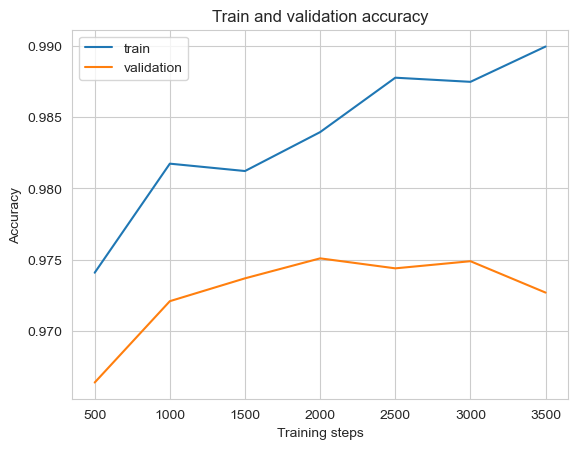

Validation accuracy: 0.973
Test accuracy: 0.976


In [8]:
"plot training and validation accuracies"
steps = (np.arange(len(train_accuracies), dtype=int) + 1) * validation_every_steps

plt.figure()
# Plot training and validation accuracies
# where plot(steps, accuracies,label) mean steps on x-axis and accuracies on y-axis, and label is for legend
plt.plot(steps, train_accuracies, label='train')
plt.plot(steps, validation_accuracies, label='validation')
plt.xlabel('Training steps')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Train and validation accuracy")
plt.show()

" Evaluate test set"
with torch.no_grad():# no gradients needed for test evaluation
    model.eval() # set the model to evaluation mode
    test_accuracies = []
    for inputs, targets in test_loader:
        # Forward pass. getting output for the model using inputs
        output = model(inputs)
        # Compute loss. based on output model and targets
        loss = loss_fn(output, targets)
        # Get the predicted class by taking the index of the maximum logit for each sample
        predictions = output.max(1)[1]

        # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy_score(targets, predictions) * len(inputs))
    # Compute overall test accuracy by summing correct test_accuracies and dividing by total number of samples of test set
    test_accuracy = np.sum(test_accuracies) / len(test_dataset)
    print(f"Validation accuracy: {validation_accuracies[-1]:.3f}")
    print(f"Test accuracy: {test_accuracy:.3f}")
    
    model.train()

    "train error < validation error < test error"
    " train accuracy > validation accuracy > test accuracy"


### Assignment 2

1. Note the performance of the standard feedforward neural network. Add a [2D convolution layer](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) before the first layer. Insert the utility module `PrintSize` to check the size of the tensor at any point in `Sequential`, and notice that the size of the image reduces after the convolution. This can cause loss of information, and can be avoided by using adequate padding in the convolutional layer.
  Does adding a convolutional layer increase the generalization performance of the network (try num_filters=32 and filter_size=5 as a starting point)?
  
2. Can the performance be increases even further by stacking more convolution layers?

3. We now have a deeper network than the initial simple feedforward network. What happens if we replace all convolutional layers with linear layers? Is this deep feedforward network performing as well as the convolutional one?
 
4. Max-pooling is a technique for decreasing the spatial resolution of an image while retaining the important features. Effectively this gives a local translational invariance and reduces the computation by a factor of four. In the classification algorithm which is usually desirable. You can either: 
 
   - add a maxpool layer (see the PyTorch docs, and try with kernel_size=2 and stride=2) after the convolution layer, or
   - add stride=2 to the arguments of the convolution layer directly.
     
  Verify that this decreases the spatial dimension of the image (insert a `PrintSize` module in the `Sequential`). Does this increase the performance of the network? Note that, to increase performance, you may need to stack multiple layers, increase the number of filters, or tune the learning rate.

5. Dropout is a very useful technique for preventing overfitting. Try to add a DropoutLayer after some of the convolution layers. You may observe a higher validation accuracy but lower train accuracy. Can you explain why this might be the case?
 
6. Batch normalization may help convergence in larger networks as well as generalization performance. Try to insert batch normalization layers into the network.


Again, if you didn't already, you really should [watch this video](https://www.youtube.com/watch?v=AgkfIQ4IGaM).